 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..

In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [5]:
observation = 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 2
# Overall Time Period
start_time='2020-08-01' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01' # Begin Vaccination Wave


train_test_split_time= '2020-12-01'


dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs_train, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=train_test_split_time, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs_train[observation], requires_grad=False, device=device, dtype=dtype)

# Initialize Observations Testing
df_obs_test, _ = initialize_observations(df_obs_initial, start=train_test_split_time, end=end_time, rolling_avg=rolling_avg_obs)
observed_test = torch.tensor(df_obs_test[observation], requires_grad=False, device=device, dtype=dtype)

# Create df_obs
observed_train_test = torch.concat((observed_train, observed_test))
df_obs = pd.concat([df_obs_train, df_obs_test])
df_obs = df_obs.reset_index(drop=True)
df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-08-01,0.5,61.0,3.5
1,2020-08-02,0.0,71.0,3.0
2,2020-08-03,0.0,97.5,4.5


In [7]:
#for column in df_obs.columns:
#  plt.plot(df_obs['Date'], df_obs[column])
#  plt.title(column)
#  plt.show()

# Experiment Settings

In [8]:
method_type = 'linear'
#method_type = 'nn'

#input_type = 'factor_data'
input_type = 'group_data'
#input_type = 'mobility_data'

# Load Input Data

In [9]:
if input_type == 'factor_data':
  input_data_cols = ['F0_cautious_behaviour',  'F1_perception_advice'] #['F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']
  input_data_train, input_data_test = get_model_input(start=start_time, end=end_time, split_date=train_test_split_time, path='data/modeling/fa_data_model_input.csv', rolling_avg=7, input_data_cols=input_data_cols)
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/fa_data_model_input.csv', rolling_avg=7, input_data_cols=input_data_cols)

elif input_type == 'group_data':
  input_data_cols = ''
  input_data_train, input_data_test = get_model_input(start=start_time, end=end_time, split_date=train_test_split_time, path='data/modeling/group_percentage_non_careful.csv', rolling_avg=7, input_data_cols=None)
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/group_percentage_non_careful.csv', rolling_avg=7, input_data_cols=None)
elif input_type == 'mobility_data':
  input_data_cols = ['google_workplaces', 'google_residential', 'google_transit'] #['apple_driving', 'apple_walking', 'apple', 'google_retail', 'google_grocery', 'google_workplaces', 'google_residential', 'google_transit', 'google', 'telco', 'applegoogle']
  input_data_train, input_data_test = get_model_input(start=start_time, end=end_time, split_date=train_test_split_time, path='data/modeling/mobility_data_denmark.csv', rolling_avg=7, input_data_cols=input_data_cols)
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/mobility_data_denmark.csv', rolling_avg=7, input_data_cols=input_data_cols)
input_data_size = input_data.shape[1]
input_data_size

1

## Initialize Model Parameter

### Initialize method parameter

In [10]:
if method_type == 'linear':
  method = Linear(device=device, dtype=dtype, input_size=input_data_size)
  
elif method_type == 'nn':
  method = NN(device=device, dtype=dtype, input_size=input_data_size)

### Initialize alpha and phi

In [11]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(0.0102, requires_grad=True),
  'phi': tensor(-0.0020, requires_grad=True)},
 'real_values': {'alpha': tensor(0.0280, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

## Load Method Input Data

# Optimization

## Training

Step: 0, Learning Rate: 0.00999 Time: 0.134, Comparison Loss: 15546.841796875


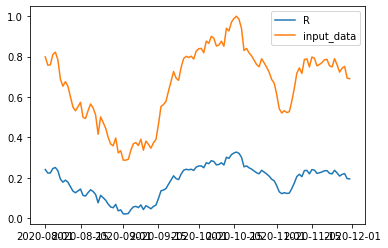

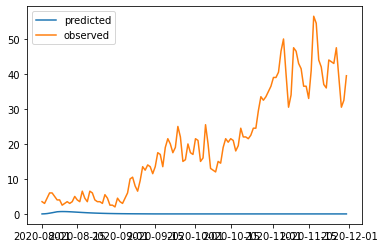

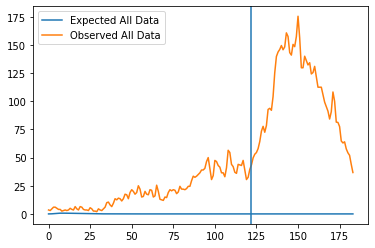

Step: 50, Learning Rate: 0.00950254422568834 Time: 0.1115, Comparison Loss: 9850.2353515625


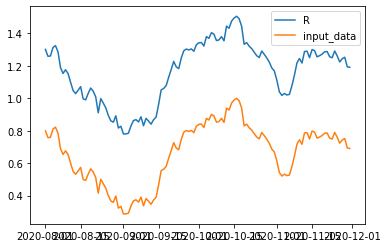

Step: 100, Learning Rate: 0.009038873549665948 Time: 0.0627, Comparison Loss: 3687.694091796875


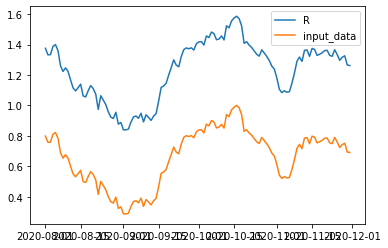

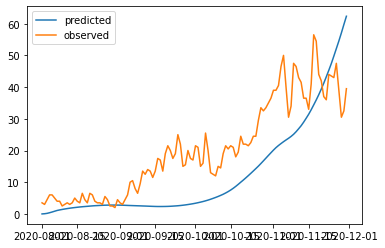

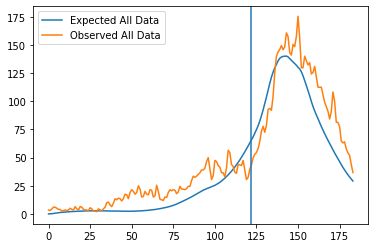

Step: 150, Learning Rate: 0.008597827393003531 Time: 0.0662, Comparison Loss: 3622.4951171875


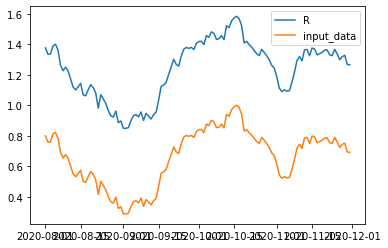

Step: 200, Learning Rate: 0.008178301806491574 Time: 0.0856, Comparison Loss: 3580.0380859375


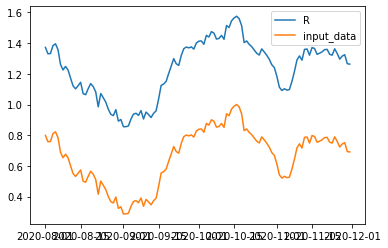

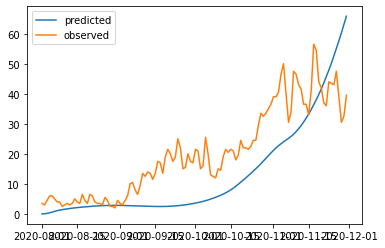

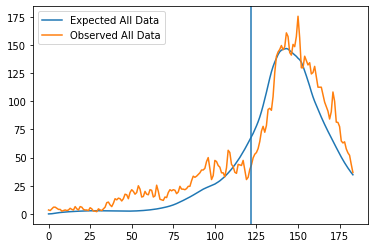

Step: 250, Learning Rate: 0.00777924670742873 Time: 0.0536, Comparison Loss: 3534.051025390625


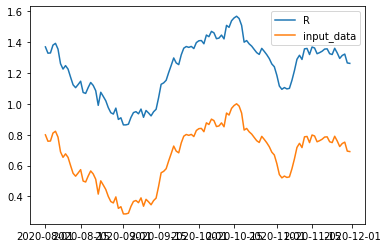

Step: 300, Learning Rate: 0.007399663251239432 Time: 0.0387, Comparison Loss: 3485.46484375


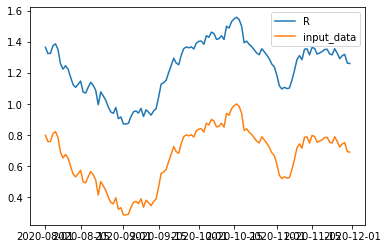

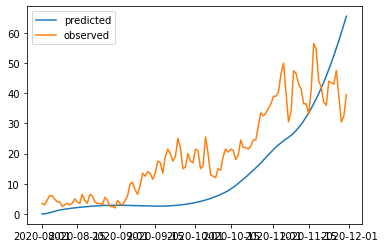

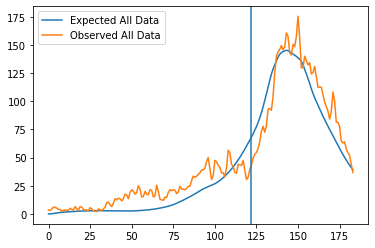

Step: 350, Learning Rate: 0.007038601331341688 Time: 0.0612, Comparison Loss: 3434.974365234375


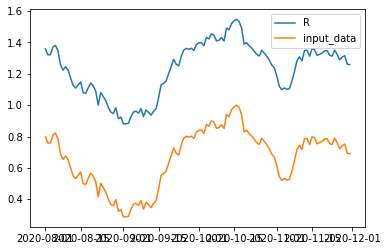

Step: 400, Learning Rate: 0.006695157201007331 Time: 0.0429, Comparison Loss: 3383.111083984375


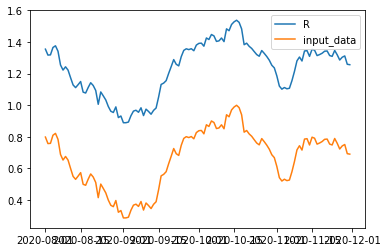

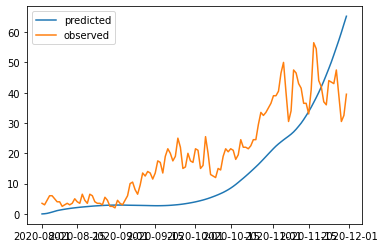

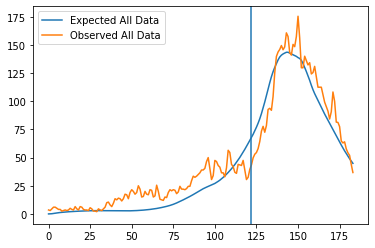

Step: 450, Learning Rate: 0.006368471211262053 Time: 0.0395, Comparison Loss: 3330.294189453125


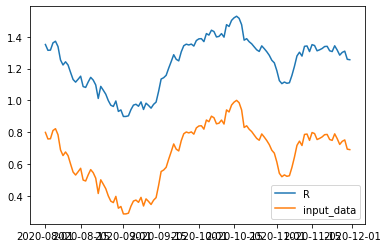

Step: 500, Learning Rate: 0.006057725659163231 Time: 0.0399, Comparison Loss: 3276.861083984375


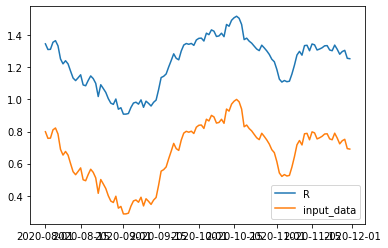

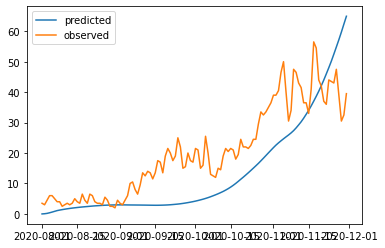

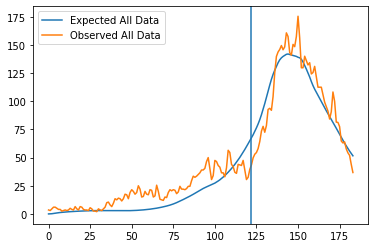

Step: 550, Learning Rate: 0.0057621427410696376 Time: 0.041, Comparison Loss: 3223.0849609375


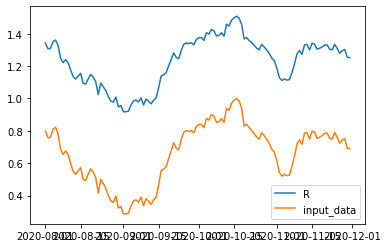

Step: 600, Learning Rate: 0.005480982605780108 Time: 0.0424, Comparison Loss: 3169.19189453125


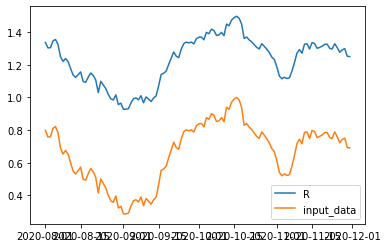

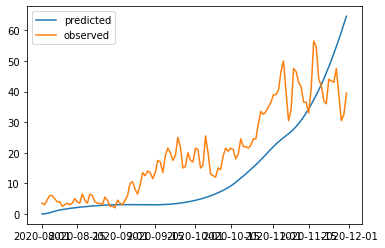

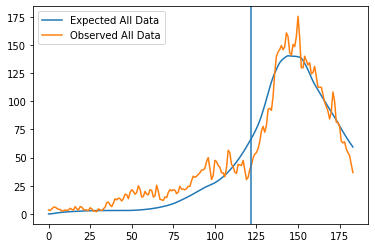

Step: 650, Learning Rate: 0.005213541502668067 Time: 0.0385, Comparison Loss: 3115.37109375


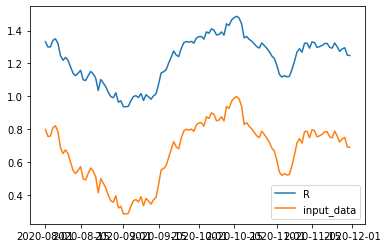

Step: 700, Learning Rate: 0.004959150020176671 Time: 0.038, Comparison Loss: 3061.777587890625


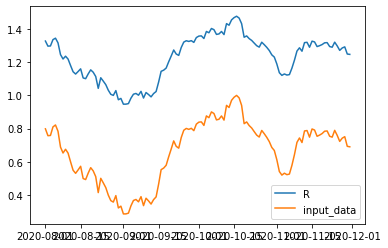

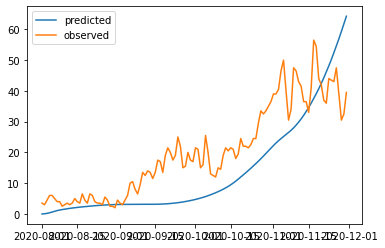

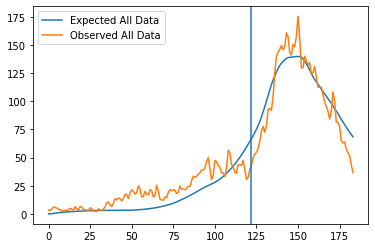

Step: 750, Learning Rate: 0.004717171410265472 Time: 0.0375, Comparison Loss: 3008.54443359375


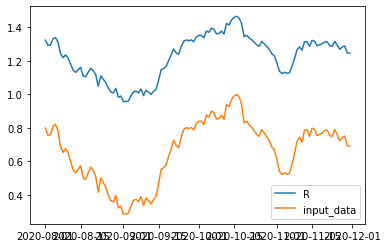

Step: 800, Learning Rate: 0.004486999994614646 Time: 0.0394, Comparison Loss: 2955.7841796875


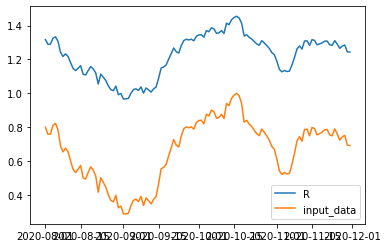

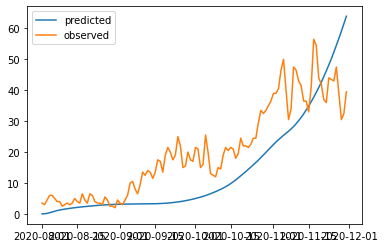

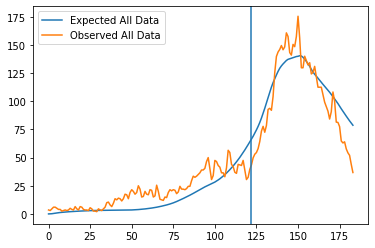

Step: 850, Learning Rate: 0.004268059648597501 Time: 0.0404, Comparison Loss: 2903.590576171875


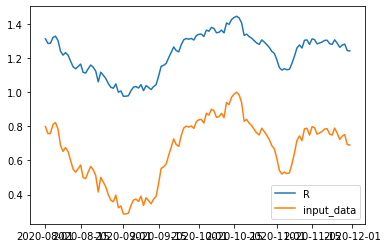

Step: 900, Learning Rate: 0.0040598023592265855 Time: 0.0346, Comparison Loss: 2852.044677734375


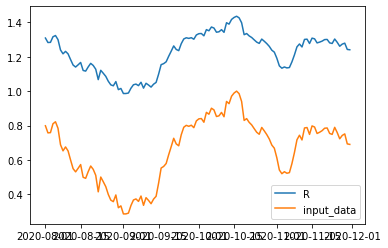

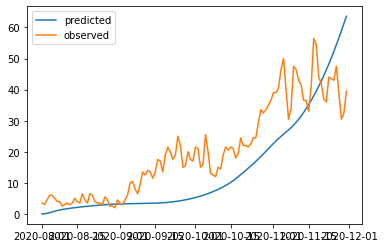

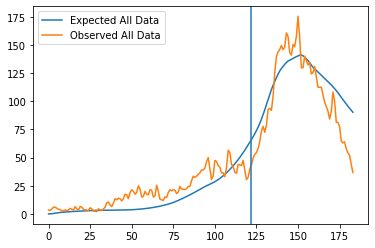

Step: 950, Learning Rate: 0.0038617068534639145 Time: 0.0398, Comparison Loss: 2801.215576171875


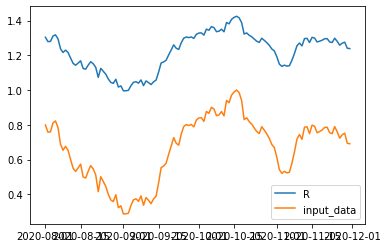

In [12]:
from torch.optim.lr_scheduler import ExponentialLR

epochs = 1000
# model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']] + [dict_param['prime_values']['epsilon']]

params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi']]
if observation == 'hospitalization':
  params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)

for i in range(epochs):
  iteration_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  dict_param = transform_prime_variables(dict_param)

  # forward pass
  expected = epid_model(R=method.calculate_R(input_data_train), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation][:df_obs_train.shape[0]]
  
  # calc loss
  comparison_loss_train =  calc_mse(expected, observed_train) * dict_param['real_values']['phi'] #calc_poisson_loss(expected, observed_train) * dict_param['real_values']['phi']# #calc_negative_binomnial_loss(expected, observed_train, dict_param['real_values']['phi']) #
  method_loss = method.calculate_loss()
  model_param_loss = calc_prior_loss(dict_param, device, dtype)
  loss = comparison_loss_train + model_param_loss + method_loss

  # backward pass
  loss.backward()
  optimizer.step()
  scheduler.step()
  
  
  with torch.no_grad():
    if i % 50==0:
        current_time = round((time.time() - iteration_time),4)
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        expected_test = epid_model(R=method.calculate_R(input_data_test), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation][-df_obs_test.shape[0]:]
        print(f"Step: {i}, Learning Rate: {current_lr} Time: {current_time}, Comparison Loss: {comparison_loss_train}")
        plt.plot(df_obs_train['Date'], method.calculate_R(input_data_train).cpu().detach().numpy(), label='R')
        plt.plot(df_obs_train['Date'], input_data_train, label='input_data')
        plt.legend()
        plt.show()
    if i % 100==0:
      plt.plot(df_obs_train['Date'], expected.cpu().detach().numpy(), label='predicted')
      plt.plot(df_obs_train['Date'], observed_train.cpu().detach().numpy(), label='observed')
      plt.legend()
      plt.show()

      expected_train_test = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
      plt.plot(expected_train_test.cpu().detach().numpy(),label='Expected All Data')
      plt.plot(observed_train_test.cpu().detach().numpy(),label='Observed All Data')
      plt.axvline(x=observed_train.shape[0])
      plt.legend()
      plt.show()


In [13]:
comparison_loss_train / dict_param['real_values']['phi']

tensor(114.3794, grad_fn=<DivBackward0>)

# Evaluation

## Train and Test Time 

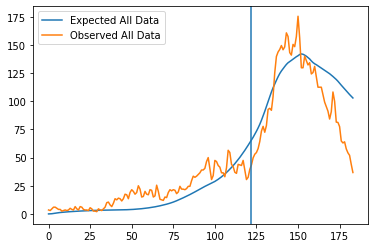

In [14]:
expected_train_test = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
plt.plot(expected_train_test.cpu().detach().numpy(),label='Expected All Data')
plt.plot(observed_train_test.cpu().detach().numpy(),label='Observed All Data')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

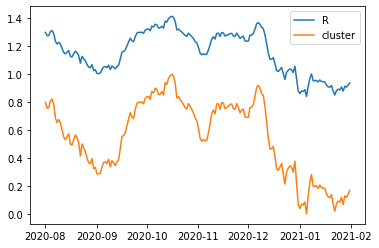

In [15]:
# Plot R-Value & Cluster Percentage
plt.plot(df_obs['Date'], method.calculate_R(input_data).cpu().detach().numpy(), label='R')
plt.plot(df_obs['Date'], input_data, label='cluster')
plt.legend()
plt.show()

## Eval on Test Data


Comparison Loss Train: 2752.156982421875 - Comparison Loss Test: 17710.421875


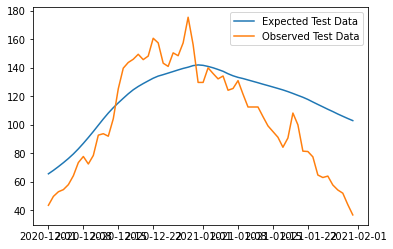

In [16]:
expected_test = expected_train_test[-df_obs_test.shape[0]:]
comparison_loss_test = calc_mse(expected_test, observed_test) * dict_param['real_values']['phi']
print(f'Comparison Loss Train: {comparison_loss_train} - Comparison Loss Test: {comparison_loss_test}')

plt.plot(df_obs_test['Date'], expected_test.cpu().detach().numpy(),label='Expected Test Data')
plt.plot(df_obs_test['Date'], observed_test.cpu().detach().numpy(),label='Observed Test Data')
plt.legend()
plt.show()

## Eval What IF

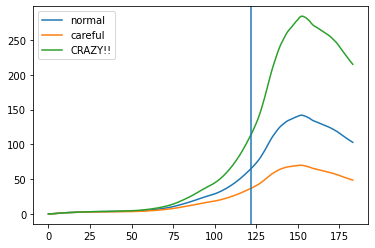

In [17]:
expected_normal = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_careful= epid_model(R=method.calculate_R(input_data*0.9), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_crazy = epid_model(R=method.calculate_R(input_data*1.1), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

plt.plot(expected_normal.cpu().detach().numpy(),label='normal')
plt.plot(expected_careful.cpu().detach().numpy(),label='careful')
plt.plot(expected_crazy.cpu().detach().numpy(),label='CRAZY!!')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

# Eval Input Data - R-Value

In [18]:
set(method.model.parameters())

{Parameter containing:
 tensor([[0.5750]], requires_grad=True), Parameter containing:
 tensor([0.8400], requires_grad=True)}

Slope: 0.5750058238441221, intercept: 0.8399689513798989, r-squared: 0.9999999999999527


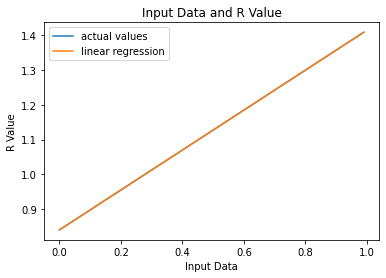

In [19]:
range = np.arange(0,1, 0.01)

if input_data_size == 1:
  from scipy import stats

  x = range
  y = np.squeeze(method.calculate_R(x).cpu().detach().numpy())

  slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
  y_linreg = intercept + slope * x
  print(f'Slope: {slope}, intercept: {intercept}, r-squared: {r_value**2}')
  plt.plot(x, y, label='actual values')
  plt.plot(x, y_linreg, label='linear regression')
  plt.xlabel('Input Data')
  plt.ylabel('R Value')
  plt.title('Input Data and R Value')
  plt.legend()
  plt.show()

elif input_data_size == 2:
  from mpl_toolkits.mplot3d import axes3d
  from matplotlib import cm
  from matplotlib.ticker import LinearLocator

  x = range
  y = range
  X,Y = np.meshgrid(x,y)

  X_new = X.reshape(-1)
  Y_new = Y.reshape(-1)
  input_data_plot = np.stack([X_new, Y_new], axis=1)
  rvalue_plot = method.calculate_R(input_data_plot).cpu().detach().numpy().reshape(100,100)


  fig = plt.figure(figsize=(12,8))
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlabel(input_data_cols[0])
  ax.set_ylabel(input_data_cols[1])
  ax.set_zlabel('R-Value')

  # Plot the surface.
  surf = ax.plot_surface(X, Y, rvalue_plot, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

  # Customize the z axis.
  ax.zaxis.set_major_locator(LinearLocator(10))

  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)
  #fig.savefig("images/Factor01_RValue_Comparison_Linear.png")
  plt.show()

elif input_data_size == 3:
  range = np.arange(0,1.1, 0.1)

  x = range
  y = range
  z = range
  X,Y,Z = np.meshgrid(x,y,z)

  X_new = X.reshape(-1)
  Y_new = Y.reshape(-1)
  Z_new = Z.reshape(-1)
  input_data_plot = np.stack([X_new, Y_new, Z_new], axis=1)
  rvalue_plot = method.calculate_R(input_data_plot).cpu().detach().numpy().reshape(-1)

  import plotly.graph_objects as go

  fig = go.Figure(data=[go.Scatter3d(
      x=X_new,
      y=Y_new,
      z=Z_new,
      mode='markers',
      marker=dict(
          size=25,
          color=rvalue_plot,
          colorbar=dict(title="R-Value"),
          colorscale='Viridis',
          opacity=0.95
      )
  )])
  fig.update_layout(title={
          'text': "Relationship Factors and R Value for " + str(method.model)[:5],
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'},
                    scene = dict(
                      xaxis_title=input_data_cols[0],
                      yaxis_title=input_data_cols[1],
                      zaxis_title=input_data_cols[2]),
                      width=1400, height=800,
                      margin=dict(r=0, b=0, l=0, t=0))
  #fig.write_html('images/3dplot_factor_rvalue_nn.html')
  fig.show()

# Eval Newly Infected

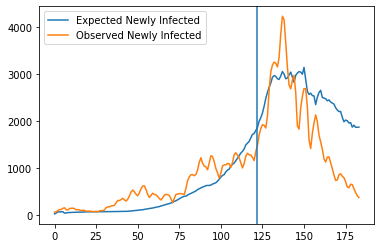

In [20]:
expected_newly = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)['newly_infected']

plt.plot(expected_newly.cpu().detach().numpy(),label='Expected Newly Infected')
plt.plot(df_obs['newly_infected'],label='Observed Newly Infected')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

# Save calculated Hospitalisation

In [21]:
df_save = pd.DataFrame()
df_save['date'] = df_obs.Date
df_save['expected_hospitalisation'] = expected_normal.cpu().detach().numpy()
df_save.head()

,date,expected_hospitalisation
0,2020-08-01,2.500000e-14
1,2020-08-02,5.819460e-02
2,2020-08-03,1.750770e-01
3,2020-08-04,3.766712e-01
4,2020-08-05,6.020228e-01


In [23]:
details = ''.join(filter(str.isalnum, str(input_data_cols)))
save_path = 'data/modeling/results/split/expected_hospitalizations_' + method_type + '_' + input_type + '_' + str(input_data_size) + '_' + details +'.csv'
#df_save.to_csv(save_path, index=False)